# Coursework I

This notebook describes the first part of the ML coursework (code).  This part builds on work that you have already done during the labs.  The purpose of this coursework, along with the previous lab work, is to:
- Get familiar with **common python modules / functions** used for ML in python
- Get practical experience **implementing** ML methods in python  
- Get practical experience regarding **parameter selection** for ML methods
- Get practical experience on **evaluating** ML methods and applying cross-validation

Notes:
- CW based on work that you did in the lab - don't use libraries that implement kNN or cross-validation.  We want to see your code!
- For more details, read the coursework PDF on learn.gold

In [67]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn import datasets

# Load the IRIS dataset, as in the labs
iris = datasets.load_iris()

#Set X equal to features, Y equal to the targets
X=iris.data 
y=iris.target

mySeed=1234567

## 1. Exploratory Data Analysis

In Lab 2, we discussed how the first part of tackling an ML problem is visualization, in order to understand some of the properties of the problem at-hand.  In the same lab, you were asked to reproduce a figure that plots pairs of features used in our problem.  Fill-in the code you used to plot this figure from Lab 2 in the cell below.  

You should create a function that given data X and labels y plots the 4x4 grid.  The function should be invoked as
    
    myplotGrid(X,y)
    
where X is your training data and y are the labels

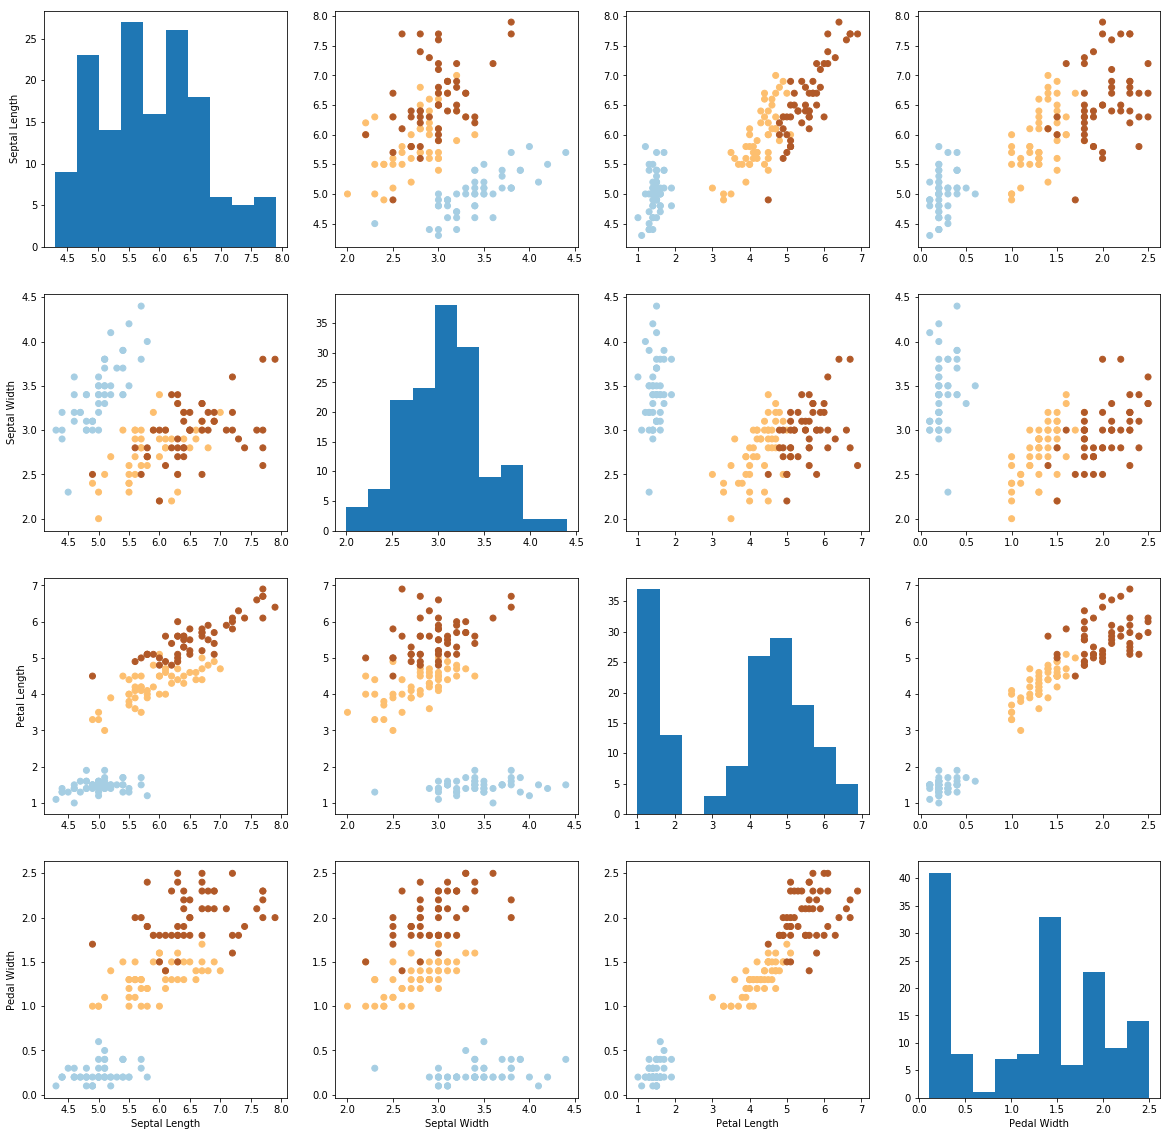

In [68]:
def myplotGrid(X,y):
    fig = plt.figure(figsize=(20,20))
    pltNum = 1
    for i in range (0, 4):
        for j in range (0, 4):
            ax = fig.add_subplot(4,4,pltNum)
            if (i == j): # plots histograms
                plt.hist(X[:,i])
            else: # plots scatter graphs
                plt.scatter(X[:, j], X[:, i], c=y, cmap=plt.cm.Paired)
            
            # adds labels
            if(pltNum%4 == 1):
                ylabel = ''
                if(i==0):
                    ylabel = 'Septal Length'
                if(i==1):
                    ylabel = 'Septal Width'
                if(i==2):
                    ylabel = 'Petal Length'
                if(i==3):
                    ylabel = 'Pedal Width'
                ax.set_ylabel(ylabel)
            if(pltNum > 12):
                xlabel = ''
                if(j==0):
                    xlabel = 'Septal Length'
                if(j==1):
                    xlabel = 'Septal Width'
                if(j==2):
                    xlabel = 'Petal Length'
                if(j==3):
                    xlabel = 'Pedal Width'
                ax.set_xlabel(xlabel)
            pltNum+=1
        
myplotGrid(X,y)

### 1.2. Exploratory Data Analysis under noise

When data are collected under real-world settings (e.g., from webcams or other errors) they usually contain some amount of noise that makes classification more challenging. In the cell below, invoke your exploratory data analysis function above on a noisy version of your data X.

Try to perturb your data with some Gaussian noise,


    np.random.seed(mySeed) # initialize random seed to replicate results over different runs
    XN=X+np.random.normal(0,0.5,X.shape)
    
and then invoke

    myplotGrid(XN,y)

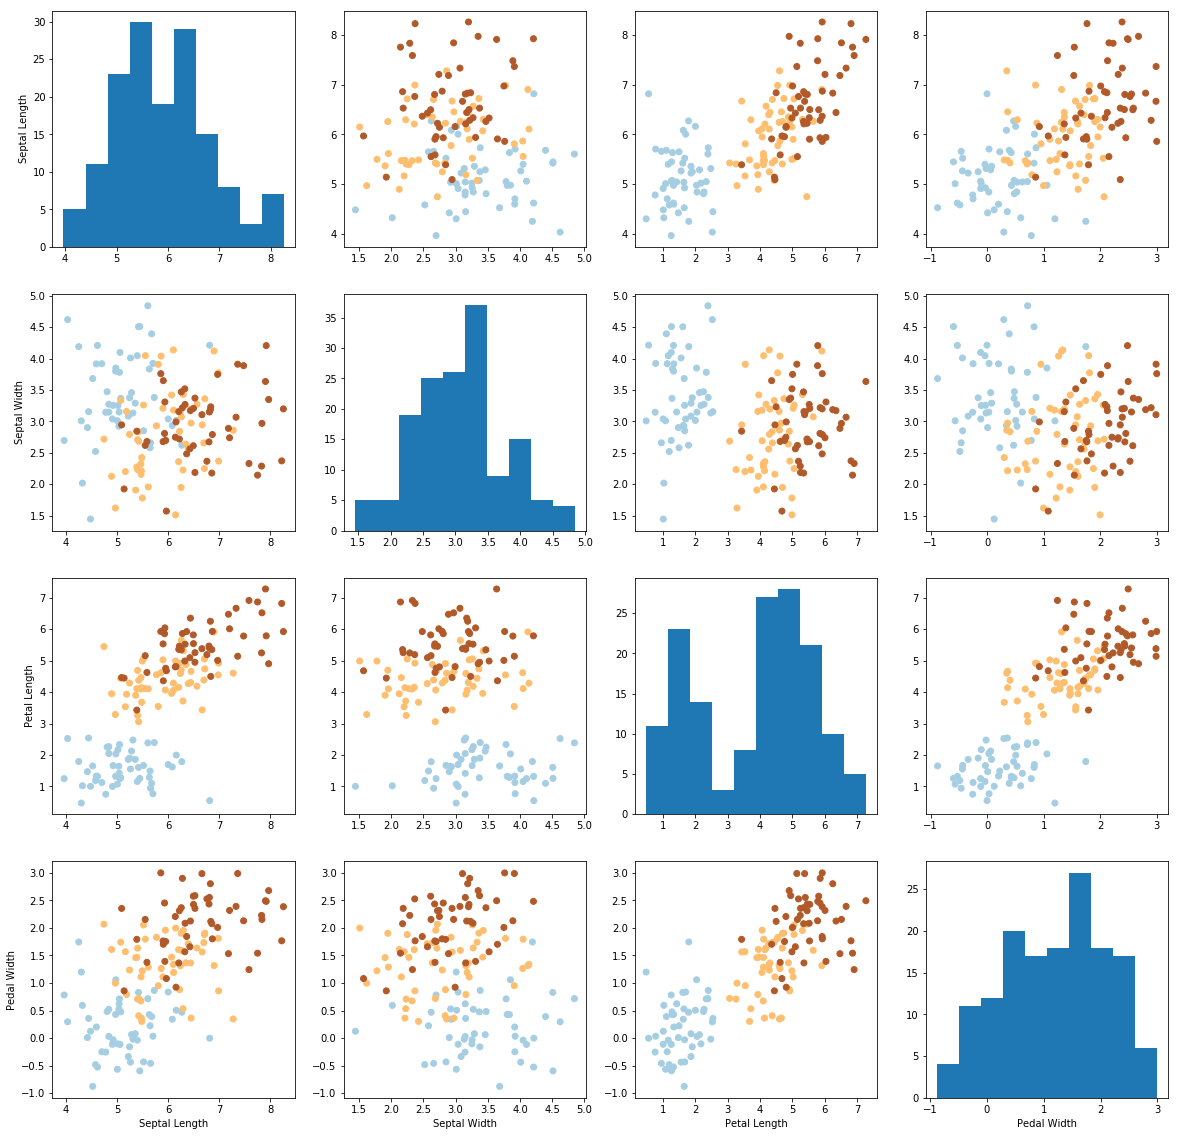

In [69]:
np.random.seed(mySeed) # initialize random seed to replicate results over different runs
XN=X+np.random.normal(0,0.5,X.shape)

myplotGrid(XN,y)

## 2. Implementing kNN

In the cell below, develop your own code for performing k-Nearest Neighbour classification.  You are guided to do this by following the notebook in Lab 4.  Define a function that performs k-NN given a set of data.  Your function should be invoked similary to:

        y_ = mykNN(X,y,X_,options)
        
where X is your training data, y is your training outputs, X\_ are your testing data and y\_ are your predicted outputs for X\_.  The options argument (can be a list or a set of separate arguments depending on how you choose to implement the function) should at least contain the number of neighbours to consider as well as the distance function employed.

In [70]:
def mykNN(X,y,X_,options):
    # X : Training data
    # y : Training targets
    # X_ : Testing data
    # option : [n neighbours, distance metric]
    y_pred = []
    
    def euclideanDistance(in1,in2):
        ans = 0.0
        for i in range(0,len(in1)):
            ans += (in1[i] - in2[i])**2
        return ans**0.5

    def manhattenDistance(in1,in2):
        ans = 0.0
        for i in range(0,len(in1)):
            ans += abs(in1[i] - in2[i])
        return ans
    
    def chebyshevDistance(in1, in2):
        ans = 0.0
        for i in range(0,len(in1)):
            a = abs(in1[i] - in2[i])
            if(a > ans):
                ans = a
        return ans
    
    def minkowskiDistance(in1, in2, p):
        ans = 0.0
        for i in range(0,len(in1)):
            ans += (abs(in1[i] - in2[i])**p)
        return ans**(1/p)
            
    # x_ : Test data
    # X : Training data
    # n : Number of neighbours to find
    def getNeighbours(X_,X, options):
        dists = []
        nIndicies = [0]
        # Calculate distances using the metric
        if(options[1] == 0):
            for i in range(0,len(X)):
                dists.append(euclideanDistance(X_,X[i]))
        elif(options[1] == 1):
            for i in range(0,len(X)):
                dists.append(manhattenDistance(X_,X[i]))
        else:
            for i in range(0,len(X)):
                dists.append(euclideanDistance(X_,X[i]))
    
        # Builds list from smallest distance (list[0]) to largest (list[-1])
        for i in range(1,len(X)):
            if(dists[i] < dists[nIndicies[-1]]):
                index = -2
                extend = 'True'
                for j in range(1,len(nIndicies)):
                    if(dists[i] > dists[nIndicies[index]]):
                        nIndicies.insert(index+1, i)
                        extend = 'False'
                        break
                    index -= 1
                    
                if(extend=='True'):
                    nIndicies.insert(0, i)
            
                if(len(nIndicies) > options[0]):
                    del nIndicies[-1]
            else:
                if(len(nIndicies) < options[0]):
                    nIndicies.append(i)
        return nIndicies # indices of n-nearest neighbours in training data


    def assignLabel(nLabels):
        if(len(nLabels) == 1):
            return nLabels[0]
        labelNum = []
        label = 0
        largest = 0
        for i in range(0,len(np.unique(y))):
            labelNum.append(0)
        for i in range(0, len(nLabels)):
            labelNum[nLabels[i]] += 1
        for i in range(0,len(labelNum)):
            if(labelNum[i] > largest):
                largest = labelNum[i]
                label = i
        return label # label assigned to test point x_
    
    for i in range(0,len(X_)):
        n = getNeighbours(X_[i], X, options)
        y_pred.append(assignLabel(y[n]))
        
    return y_pred

## 3. Nested Cross-validation using your implementation of KNN

In the cell below, develop your own code for performing 5-fold nested cross-validation along with your implemenation of k-NN above.  Again, you are guided to complete this task by following the appropriate notebook in Lab 4.  Your code for nested cross-validation should invoke your kNN function (see above).  You cross validation function should be invoked similary to:

    accuracy_fold=myNestedCrossVal(X,y,5,list(range(1,11)),['euclidean','manhattan'],mySeed)
    
where X is your data matrix (containing all samples and features for each sample), 5 is the number of folds, y are your known output labels, ``list(range(1,11)`` evaluates the neighbour parameter from 1 to 10, and ``['euclidean','manhattan']`` evaluates the two distances on the validation sets.  mySeed is simply a random seed to enable us to replicate your results.

**Notes:** 
- you should perform nested cross-validation on both your original data X, as well as the data pertrubed by noise as shown in the cells above (XN)
- you should implement/validate at least two distance functions
- you should evaluate number of neighbours from 1 to 10
- your function should return a list of accuracies per fold
- for each fold, your function should print:
  - the accuracy per distinct set of parameters on the validation set
  - the best set of parameters for the fold after validation
  - the confusion matrix per fold (on the testing set)


In [71]:
def myAccuracy(y_test,y_pred):
    accuracy = (len(y_test) - len(np.where(y_test != y_pred)[0])) / len(y_test)
    return accuracy

In [72]:
def myConfMat(y_test,y_pred,classNum):
    C = np.zeros((classNum,classNum))  # initialize the confusion matrix to zeros
    
    #loops through all results and update the confusion matrix
    for i in range(0, len(y_test)):
        C[y_test[i]][y_pred[i]] += 1
    return C

In [85]:
# nested cross validation function
# X : data / features
# y : outputs
# foldK - number of folds
# nns - list of number of neighbours parameter for validation
# dists - list of distances for validation
# mySeed - random seed
# returns: accuracy over 5 folds (list)

def myNestedCrossVal(X,y,foldK,nns,dists, mySeed):
    np.random.seed(mySeed)
    accuracy_fold=[]
    totalConfMat=np.zeros((3,3))
    # Randomizes indicies then splits the data into k folds
    indices = np.random.permutation(list(range(X.shape[0])))
    bins = np.split(indices, foldK)
    #print(bins)
    
    def distToNum(dist):
        num = 0;
        if(dist == 'euclidean'):
            num = 0
        if(dist == 'manhattan'):
            num = 1
        return num
    
    # loop through folds
    for i in range(0,foldK):
        foldTrain=[] # list to save current indices for training
        foldTest=[]  # list to save current indices for testing
        foldVal=[]   # list to save current indices for validation

        # loops through all bins, takes bin i for testing, bin i+1 for validation and the rest for testing
        for j in range(0,foldK):
            if(i==j):
                foldTest=bins[i]
            elif(i == foldK-1 and j == 0): # wrap around for validation
                foldVal=bins[0]
            elif(i+1 == j):                   
                foldVal=bins[j]
            else:
                foldTrain.extend(bins[j])
            
        #print('** Train', len(foldTrain), foldTrain)
        #print('** Val', len(foldVal), foldVal)
        #print('** Test', len(foldTest), foldTest)
        
        bestDistance=''  # stores the best distance metric here
        bestNN=-10       # stores the best number of neighbours here
        bestAccuracy=-10 # stores the best attained accuracy here (in terms of validation)
        
        # loops through all parameters (one for loop for distances, one for loop for nn)
        # trains the classifier on current number of neighbours/distance
        # obtains accuracy on validation set
        # stores parameters if result are the most accurate
        optionList = []
        for d in range(0,len(dists)):            
            for n in range(0, len(nns)):
                optionList = [nns[n], distToNum(dists[d])]
                y_pred = mykNN(X[foldTrain], y[foldTrain], X[foldVal], optionList)
                acc = myAccuracy(y[foldVal], y_pred)
                if(acc > bestAccuracy):
                    bestDistance = dists[d]
                    bestNN = nns[n]
                    bestAccuracy = acc
        
        #print('** End of val for this fold, best NN', bestNN, 'best Dist', bestDistance)
        
        #extend your training set by including the validation set
        foldTrain.extend(foldVal)
        
        optionList = [bestNN,distToNum(bestDistance)]
        y_pred = mykNN(X[foldTrain], y[foldTrain], X[foldTest], optionList)
        
        accuracy_fold.append(myAccuracy(y[foldTest], y_pred))
        confMat = myConfMat(y[foldTest], y_pred, len(np.unique(y)))
        totalConfMat += confMat
        print('===Final Cross-val on test on this fold with','\n',
              'Best NN: ',bestNN,'\n',
              'Best Dist: ',bestDistance,'\n',
              'Best Accuracy: ',myAccuracy(y[foldTest],y_pred),'\n')
        print(' Confusion Martix:','\n',confMat, '\n')
        if(i == foldK-1):
            print(' Total Confusion Matrix: ','\n',totalConfMat,'\n')
            print(' Accuracy List: ','\n', accuracy_fold,'\n')
            print(' Mean: ',np.mean(accuracy_fold),'\n')
            print(' Stadard Deviation: ',np.std(accuracy_fold))
            for i in range(0,100):
                sys.stdout.write('_')
            print('\n\n')
    return accuracy_fold;
    
# Nested crossvalidation on original data:
print('===Original Data===','\n')
accuracy_fold=myNestedCrossVal(X,y,5,list(range(1,11)),['euclidean','manhattan'], mySeed)


# Nested crossvalidation on noisy data:
print('===Noisy Data===','\n')
accuracy_fold=myNestedCrossVal(XN,y,5,list(range(1,11)),['euclidean','manhattan'], mySeed)

===Original Data=== 

===Final Cross-val on test on this fold with 
 Best NN:  3 
 Best Dist:  euclidean 
 Best Accuracy:  0.9666666666666667 

 Confusion Martix: 
 [[ 11.   0.   0.]
 [  0.  10.   1.]
 [  0.   0.   8.]] 

===Final Cross-val on test on this fold with 
 Best NN:  4 
 Best Dist:  euclidean 
 Best Accuracy:  0.9333333333333333 

 Confusion Martix: 
 [[ 12.   0.   0.]
 [  0.  11.   0.]
 [  0.   2.   5.]] 

===Final Cross-val on test on this fold with 
 Best NN:  1 
 Best Dist:  euclidean 
 Best Accuracy:  0.9333333333333333 

 Confusion Martix: 
 [[  5.   0.   0.]
 [  0.  13.   1.]
 [  0.   1.  10.]] 

===Final Cross-val on test on this fold with 
 Best NN:  4 
 Best Dist:  euclidean 
 Best Accuracy:  1.0 

 Confusion Martix: 
 [[ 11.   0.   0.]
 [  0.   7.   0.]
 [  0.   0.  12.]] 

===Final Cross-val on test on this fold with 
 Best NN:  1 
 Best Dist:  euclidean 
 Best Accuracy:  0.9666666666666667 

 Confusion Martix: 
 [[ 11.   0.   0.]
 [  0.   6.   1.]
 [  0.   0.  1